# How does $z$-projection of 3D distributions (as in aster) affect appearent shapes?
`{aduarte,gsalmon}@caltech.edu`

In [2]:
## IMPORTS
import pandas as pd
import numpy as np
import h5py
import glob

######### gabe hacky styling to emulate some of PBoC Phillips lab style conventions, however hacky. tries to make easier for nigel++
## Styling
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
# sns.set_style('ticks')

import matplotlib.colors as c
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set the property to save figures with text as text, not paths
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# default good PBoC colors
baseBlendColor=(224/255, 219/255, 209/255,1) # default background for plots
contrastColor=(209/255, 193/255, 171/255,1) # slightly darker tan for contrasts, e.g. in inset boxes
yellowTanHighlightBoxColor='#FEF0C6'
goodGreyGreenArrowColor='#CCD4C9'

### Griffin style invocation

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.path import Path
from matplotlib.patches import BoxStyle
from matplotlib.offsetbox import AnchoredText

def plotting_style(grid=False):
    """
    Sets the style to the publication style. To instantiate, simply call
    plotting_style() at the beginning of your script or notebook to force
    all matplotlib plots to adopt the scheme.

    Parameters
    ----------
    grid: bool
      If True, plots will have a thin, white grid in the background. Default
      is False.

    Returns
    -------
    colors: dict
      Returns a dictionary of the standard PBoC 2e color palette.
    """
    rc = {'axes.facecolor': '#E3DCD0',
#               'axes.spines.top': False,
#               'axes.spines.right': False,
#               'axes.spines.left': False,  # Ensure left spine is present
#               'axes.spines.bottom': False,  # Ensure bottom spine is present
#               'axes.spines.left': False, #{'color': '#E3DCD0', 'linewidth': 1.5},  # Set the spine color to the background color
#               'axes.spines.bottom': False, #{'color': '#E3DCD0', 'linewidth': 1.5},  # Set the spine color to the background color
          #'font.family': '/usr/share/fonts/truetype/LucidaSansOT.otf', #'LucidaSansOT.otf',
          'grid.linestyle': '-',
          'grid.linewidth': 0.5,
          'grid.alpha': 0.75,
          'grid.color': '#ffffff',
          'axes.grid': grid,
          'ytick.direction': 'in',
          'xtick.direction': 'in',
          'xtick.gridOn': grid,
          'ytick.gridOn': grid,
#               'ytick.major.width':8,
#               'xtick.major.width':8,
#               'ytick.major.size': 8,
#               'xtick.major.size': 8,
          'mathtext.fontset': 'stixsans',
          'mathtext.sf': 'sans',
          'legend.frameon': True,
          'legend.facecolor': '#FFEDCE',
          'figure.dpi': 150,
          'xtick.color': 'k',
          'ytick.color': 'k'
         }
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('mathtext', fontset='stixsans', sf='sans')
    sns.set_style('darkgrid', rc=rc)
    return color_palette()

def color_palette():
    """
    Returns a dictionary of the PBOC color palette
    """
    return {'green': '#7AA974', 'light_green': '#BFD598',
              'pale_green': '#DCECCB', 'yellow': '#EAC264',
              'light_yellow': '#F3DAA9', 'pale_yellow': '#FFEDCE',
              'blue': '#738FC1', 'light_blue': '#A9BFE3',
              'pale_blue': '#C9D7EE', 'red': '#D56C55', 'light_red': '#E8B19D',
              'pale_red': '#F1D4C9', 'purple': '#AB85AC',
              'light_purple': '#D4C2D9', 'dark_green':'#7E9D90', 'dark_brown':'#905426'}

def titlebox(
    ax, text, color, bgcolor=None, size=8, boxsize=0.1, pad=0.05, **kwargs
):
    """
    Sets a colored title box above the plot, spanning the entire plot width.

    Parameters
    ----------
    ax : matplotlib axis object
      The axis on which you want to add the titlebox.
    text: str
      The title tect
    bgcolor: str or None
      The background color of the title box. Default is no color (blank).
    size:  int
      Size of the text font
    boxsize: float [0, 1]
      Fraction of the total plot height to be occupied by the box. Default is 10% (0.1).
    pad: float
      The padding space between the title box and the top of the plot.

    """
    boxsize=str(boxsize * 100)  + '%'
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size=boxsize, pad=pad)
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.spines["top"].set_visible(False)
    cax.spines["right"].set_visible(False)
#     cax.spines["bottom"].set_visible(False)
#     cax.spines["left"].set_visible(False)

#     cax.spines["bottom"].set_visible(True)
#     cax.spines["left"].set_visible(True)
#     cax.spines["left"].set_color("white")
#     cax.spines["bottom"].set_color("white")
#     cax.spines["bottom"].set_color("white")

#     cax.set_ticks_position('both')  # Adding ticks to both top and bottom
#     cax.yaxis.set_tick_params(direction='in', which='both', color='white')  # The bottom will maintain the default of 'out'


    plt.setp(cax.spines.values(), color=color)
    if bgcolor != None:
        cax.set_facecolor(bgcolor)
    else:
        cax.set_facecolor("white")
    at = AnchoredText(text, loc=10, frameon=False, prop=dict(size=size, color=color))
    cax.add_artist(at)


### Now actually call it
plotting_style()

import matplotlib.patheffects as pe
matplotlib.rcParams['axes.autolimit_mode'] = 'data'

### Test distribution
* Assume motors are spherically-symmetrically distributed in a gradient $c(r)$,
$$c(r) = c_0 \exp[-r/\lambda]. $$ 
For now, measure concentrations in scales of $c_0$ and lengths in units of $\lambda$, giving nondimensionalized,
$$c(r) = \exp[-r].$$
* Note that $r^2 = z^2 + y^2 + x^2$. Let $\rho:= \sqrt{x^2 + y^2}.$ So, $r^2 = z^2 + \rho^2.$ This means that $2r ~dr/dz = 2z$ and thus $dz = \frac{r}{z}~dr$.
* Optical projection gives,
\begin{align}
\hat{c}(\rho) & := \int_{z=-\infty}^\infty dz~ c(z,\rho) = 2 \int_{z=0}^\infty dz~ c(z,\rho) \\
& = 2\int dz~c(r)\\
& = 2\int dr \frac{r}{z} c(r) ~dr\\
& = \boxed{2\int_{r=\rho}^\infty dr \frac{r}{\sqrt{r^2 - \rho^2}} c(r)}.
\end{align}
where we used the symmetry of the distribution about $z=0$, and in the last step, the value of $r$ varies from $\rho$ (the case when $z=0$) to $\infty$ (the case when $z=\infty$).

* In case it is more convenient to reason about a restricted range of $z\in [a, b]$ for some experimental domain $[a,b]$ (e.g. from $z=0$ to $z=h$),
\begin{align}
\hat{c}(\rho) &:= \int_{z=a}^b dz ~ c(z,\rho)\\
&= \boxed{\int_{r=\sqrt{a^2 + \rho^2}}^{\sqrt{b^2 + \rho^2}} dr~ \frac{r}{\sqrt{r^2-\rho^2}}c(r)}.
\end{align}

### First, obviously confirm a few properties of the underlying spherical distribution,

Text(0.5, 0, 'radial coordinate $r$')

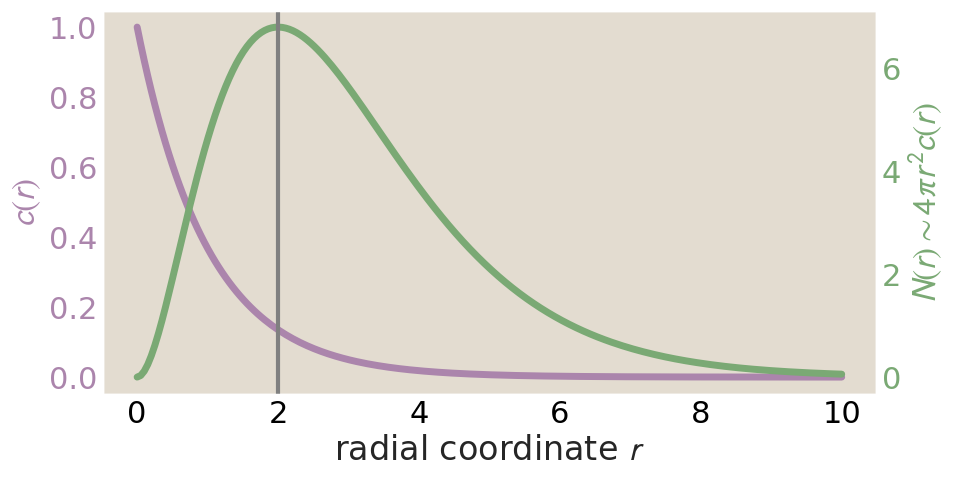

In [2]:

rVals=np.linspace(0, 10, 200)
motConcs=np.exp(-rVals)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(rVals, motConcs, lw=5, color=color_palette()['purple'])
ax2=ax.twinx()
ax2.plot(rVals, motConcs*4*np.pi*rVals**2, lw=5, color=color_palette()['green'])

# Set y-axis tick labels to the specified font color
plt.setp(ax.get_yticklabels(), color=color_palette()['purple'])
ax.tick_params(axis='y', which='both', length=0) # Hide the y-axis tick lines
ax.set_ylabel(r'$c(r)$', color=color_palette()['purple'])

plt.setp(ax2.get_yticklabels(), color=color_palette()['green'])
ax2.tick_params(axis='y', which='both', length=0)
ax2.set_ylabel(r'$N(r)\sim 4\pi r^2 c(r)$', color=color_palette()['green'])
plt.axvline(2, color='grey')

ax.set_xlabel('radial coordinate $r$')

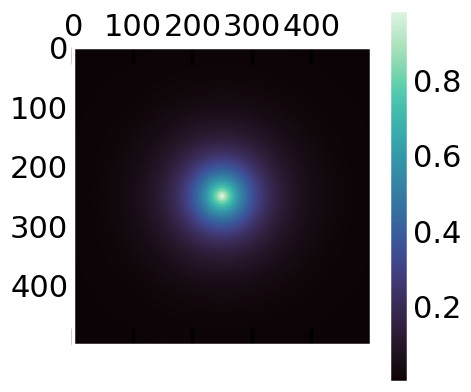

In [3]:
### simple slice
xVals=np.linspace(0,10,500)-5
yVals=np.linspace(0,10,500)-5
X, Y = np.meshgrid(xVals, yVals)
r_z0 = np.sqrt(X**2 + Y**2) # at z=0
C=np.exp(-r_z0)

plt.matshow(C, cmap=sns.color_palette('mako', as_cmap=True))
plt.colorbar()

Text(0.5, 1.0, 'proxy for number')

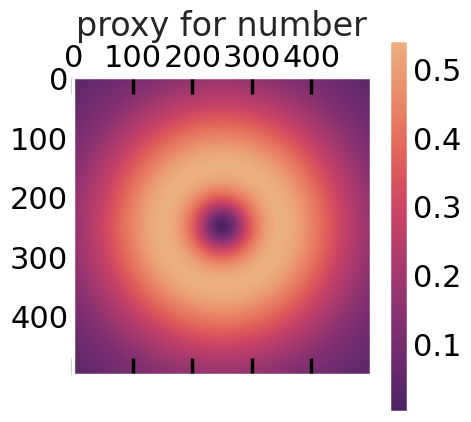

In [108]:
### simple slice
xVals=np.linspace(0,10,500)-5
yVals=np.linspace(0,10,500)-5
X, Y = np.meshgrid(xVals, yVals)
r_z0 = np.sqrt(X**2 + Y**2) # at z=0
C=np.exp(-r_z0)

plt.matshow(C*r_z0**2, cmap=sns.color_palette('flare_r', as_cmap=True))
plt.colorbar()
plt.title('proxy for number')
#plt.ticks('off')

# `OLD`: Super simple model what this looks like under projection.
* this below seems WRONG, since it apparently just computes,
$$f(\rho)\equiv \int_{\rho}^\infty ~dr ~c(r), $$
which is OBVIOUSLY NOT THE SAME as
$$\hat{c}(\rho)\equiv \int_{\rho}^\infty ~dr ~c(r) \frac{r}{\sqrt{r^2 - \rho^2}}. $$

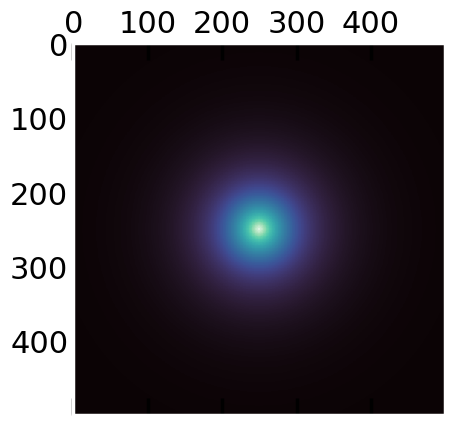

In [4]:
# perform numerical integral...
import scipy

def getProj(rho, cRfunct=lambda r: np.exp(-r)):
    result, error = scipy.integrate.quad(cRfunct, rho, np.inf)
    return 2*result

rhoBinEdgeVals=np.linspace(1e-3, 10, num=1000+1)
rhoMidVals=(rhoBinEdgeVals[:-1]+rhoBinEdgeVals[1:])/2
projCvalsForRho=[getProj(rho) for rho in rhoMidVals]

## Iteratively build up
projMap=np.zeros_like(C)
for ii in range(len(rhoMidVals)):
    # find the iith rho-radial annulus
    annulusMask=(r_z0 >= rhoBinEdgeVals[ii]) & (r_z0 < rhoBinEdgeVals[ii+1])
   # plt.matshow(annulusMask)
    projMap=projMap+annulusMask*projCvalsForRho[ii]

plt.matshow(projMap, cmap=sns.color_palette('mako', as_cmap=True))

In [46]:
# # perform numerical integral...FOR NUMBER
# import scipy

# def getProj_num(rho, cRfunct=lambda r: 4*np.pi*r**2*np.exp(-r)):
#     result, error = scipy.integrate.quad(cRfunct, rho, np.inf)
#     return 2*result

# rhoBinEdgeVals=np.linspace(1e-3, 10, num=1000+1)
# rhoMidVals=(rhoBinEdgeVals[:-1]+rhoBinEdgeVals[1:])/2
# projCvalsForRho_num=[getProj_num(rho) for rho in rhoMidVals]

# ## Iteratively build up
# projMap_Num=np.zeros_like(C)
# for ii in range(len(rhoMidVals)):
#     # find the iith rho-radial annulus
#     annulusMask=(r_z0 >= rhoBinEdgeVals[ii]) & (r_z0 < rhoBinEdgeVals[ii+1])
#    # plt.matshow(annulusMask)
#     projMap_Num=projMap_Num+annulusMask*projCvalsForRho_num[ii]

# plt.matshow(projMap_Num, cmap=sns.color_palette('flare_r', as_cmap=True))

In [45]:
# plt.plot(rhoMidVals, projCvalsForRho_num, 'r-')

In [14]:
# #### Visualize the raw transformation function itself, assuming c(r) were uniform!
# # perform numerical integral...
# import scipy

# def getProj(rho, cRfunct=lambda r: 1):
#     result, error = scipy.integrate.quad(cRfunct, rho, 10000)
#     return 2*result

# rhoBinEdgeVals=np.linspace(1e-3, 10, num=1000+1)
# rhoMidVals=(rhoBinEdgeVals[:-1]+rhoBinEdgeVals[1:])/2
# projCvalsForRho=[getProj(rho) for rho in rhoMidVals]

# ## Iteratively build up
# projMap=np.zeros_like(C)
# for ii in range(len(rhoMidVals)):
#     # find the iith rho-radial annulus
#     annulusMask=(r_z0 >= rhoBinEdgeVals[ii]) & (r_z0 < rhoBinEdgeVals[ii+1])
#    # plt.matshow(annulusMask)
#     projMap=projMap+annulusMask*projCvalsForRho[ii]

# plt.matshow(projMap, cmap=sns.color_palette('mako', as_cmap=True))
# plt.title("approximate projection map")
# plt.colorbar()

##### `20241213` i think the above is NOT the abel transform of a uniform field, in fact?

In [15]:
# #### Visualize the raw transformation function itself, assuming c(r) were uniform!
# # perform numerical integral...
# import scipy

# def getProj(rho, h):
#     cRfunct=lambda r: r/np.sqrt(r**2-rho**2)
#     result, error = scipy.integrate.quad(cRfunct, rho, np.sqrt(h**2+rho**2))
#     return 2*result

# rhoBinEdgeVals=np.linspace(1e-4, 10, num=5000+1)
# rhoMidVals=(rhoBinEdgeVals[:-1]+rhoBinEdgeVals[1:])/2
# projCvalsForRho=[getProj(rho, 50000) for rho in rhoMidVals]

# ## Iteratively build up
# projMap=np.zeros_like(C)
# for ii in range(len(rhoMidVals)):
#     # find the iith rho-radial annulus
#     annulusMask=(r_z0 >= rhoBinEdgeVals[ii]) & (r_z0 < rhoBinEdgeVals[ii+1])
#    # plt.matshow(annulusMask)
#     projMap=projMap+annulusMask*projCvalsForRho[ii]

# plt.matshow(projMap, cmap=sns.color_palette('mako', as_cmap=True))
# plt.title("approximate projection map")
# plt.colorbar()



In [16]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.integrate import quad
# import seaborn as sns

# # Define the integral function
# def radialIntegral(rho, h):
#     # If h <= rho, the integral doesn't produce a real positive value
#     # We'll just return 0 in that case.
#     if h <= rho:
#         return 0.0
#     def integrand(r):
#         return r / np.sqrt(r**2 - rho**2)
#     result, err = quad(integrand, rho, h)
#     return result

# # Example parameters
# h = 50000  # large h value
# rhoBinEdgeVals = np.linspace(1e-4, 10, num=5001)  # radial bin edges
# rhoMidVals = (rhoBinEdgeVals[:-1] + rhoBinEdgeVals[1:]) / 2

# # Compute the projection values for each annulus
# projCvalsForRho = [radialIntegral(rho, h) for rho in rhoMidVals]

# # For demonstration purposes, let's assume a 2D coordinate grid:
# # Construct a mesh of points (X, Z) and compute their radial distance r_z0.
# size = 200
# x = np.linspace(-11, 11, size)
# z = np.linspace(-11, 11, size)
# X, Z = np.meshgrid(x, z)
# r_z0 = np.sqrt(X**2 + Z**2)

# # Suppose C is a uniform array or some scalar field
# C = np.ones((size, size))

# # Build the projection map by assigning the integral result based on radial bins
# projMap = np.zeros_like(C)
# for i in range(len(rhoMidVals)):
#     annulusMask = (r_z0 >= rhoBinEdgeVals[i]) & (r_z0 < rhoBinEdgeVals[i+1])
#     projMap[annulusMask] = projCvalsForRho[i]

# # Visualize the projection map
# plt.figure(figsize=(6, 5))
# sns.heatmap(projMap, cmap="mako", cbar=True)
# plt.title("Approximate Projection Map")
# plt.show()

## New/correct Abel transforms

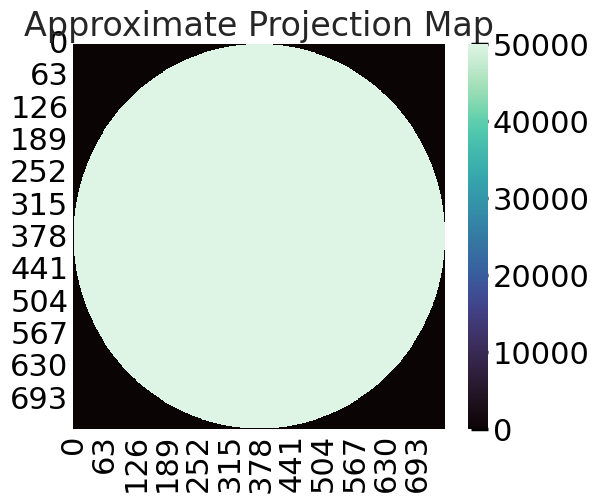

In [75]:
#### Verify numerical integral returns constant if integrand is 1 other than Jacobian part of the integral transform

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import seaborn as sns

# Define the integral function
def radialIntegral(rho, h):
    # If h <= rho, the integral doesn't produce a real positive value
    # We'll just return 0 in that case.
    # if h <= rho:
    #     return 0.0
    def integrand(r):
        return r / np.sqrt(r**2 - rho**2)
    result, err = quad(integrand, rho, np.sqrt(h**2 + rho**2))
    return result

# Example parameters
h = 50000  # large h value
rhoMin=1e-4
rhoMax=10
rhoBinEdgeVals = np.linspace(rhoMin, rhoMax, num=5001)  # radial bin edges
rhoMidVals = (rhoBinEdgeVals[:-1] + rhoBinEdgeVals[1:]) / 2

# Compute the projection values for each annulus
projCvalsForRho = [radialIntegral(rho, h) for rho in rhoMidVals]

# For demonstration purposes, let's assume a 2D coordinate grid:
# Construct a mesh of points (X, Z) and compute their radial distance r_z0.
size = 750
x = np.linspace(-rhoMax, rhoMax, size)
z = np.linspace(-rhoMax, rhoMax, size)
X, Z = np.meshgrid(x, z)
r_z0 = np.sqrt(X**2 + Z**2)

# Suppose C is a uniform array or some scalar field
C = np.ones((size, size))

# Build the projection map by assigning the integral result based on radial bins
projMap = np.zeros_like(C)
for i in range(len(rhoMidVals)):
    annulusMask = (r_z0 >= rhoBinEdgeVals[i]) & (r_z0 < rhoBinEdgeVals[i+1])
    projMap[annulusMask] = projCvalsForRho[i]

# Visualize the projection map
plt.figure(figsize=(6, 5))
sns.heatmap(projMap, cmap="mako", cbar=True)
plt.title("Approximate Projection Map")
plt.show()

(49990.0, 50010.0)

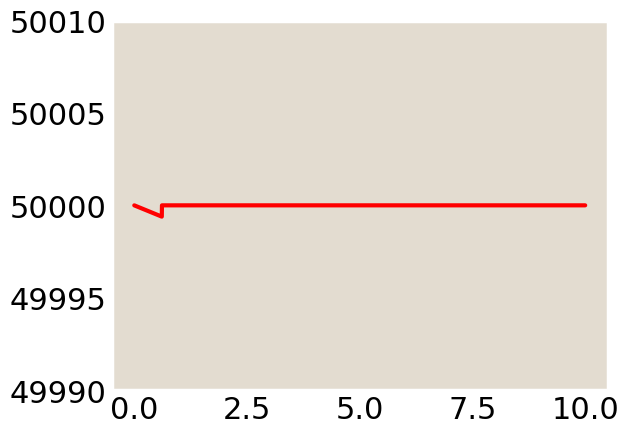

In [78]:
plt.plot(rhoMidVals, projCvalsForRho, color='r')
plt.ylim([h-10, h+10])

#### Now, just for later numerical convenience, only evaluate on grid that is smaller than rhomax (eg comfortably inside the circle above)

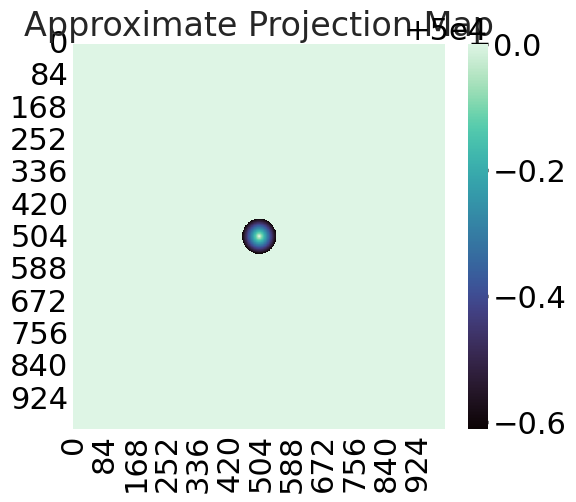

In [54]:
#### Verify numerical integral returns constant if integrand is 1 other than Jacobian part of the integral transform

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import seaborn as sns

# Define the integral function
def radialIntegral(rho, h):
    # If h <= rho, the integral doesn't produce a real positive value
    # We'll just return 0 in that case.
    if h <= rho:
        return 0.0
    def integrand(r):
        return r / np.sqrt(r**2 - rho**2)
    result, err = quad(integrand, rho, np.sqrt(h**2 + rho**2))
    return result

# Example parameters
h = 50000  # large h value
rhoMin=1e-6
rhoMax=10
rhoBinEdgeVals = np.linspace(rhoMin, rhoMax, num=5001)  # radial bin edges
rhoMidVals = (rhoBinEdgeVals[:-1] + rhoBinEdgeVals[1:]) / 2

# Compute the projection values for each annulus
projCvalsForRho = [radialIntegral(rho, h) for rho in rhoMidVals]

# For demonstration purposes, let's assume a 2D coordinate grid:
# Construct a mesh of points (X, Z) and compute their radial distance r_z0.
size = 1000
x = np.linspace(-rhoMax/1.5, rhoMax/1.5, size)
z = np.linspace(-rhoMax/1.5, rhoMax/1.5, size)
X, Z = np.meshgrid(x, z)
r_z0 = np.sqrt(X**2 + Z**2)

# Suppose C is a uniform array or some scalar field
C = np.ones((size, size))

# Build the projection map by assigning the integral result based on radial bins
projMap = np.zeros_like(C)
for i in range(len(rhoMidVals)):
    annulusMask = (r_z0 >= rhoBinEdgeVals[i]) & (r_z0 < rhoBinEdgeVals[i+1])
    projMap[annulusMask] = projCvalsForRho[i]

# Visualize the projection map
plt.figure(figsize=(6, 5))
sns.heatmap(projMap, cmap="mako", cbar=True)
plt.title("Approximate Projection Map")
plt.show()

/tmp/ipykernel_314847/3161510217.py:18: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result, err = quad(integrand, rho+tiny, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)


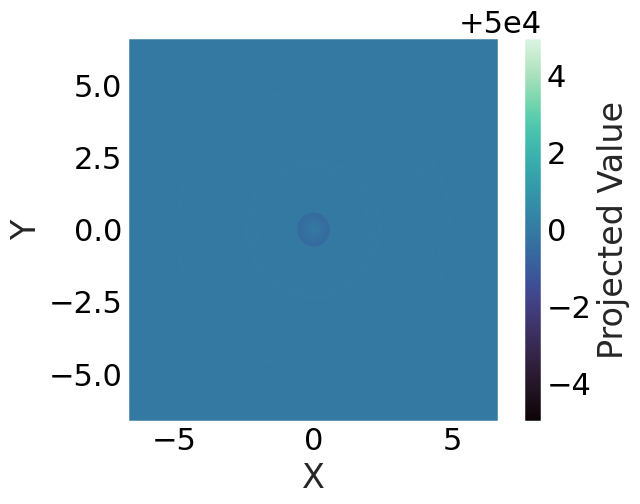

In [67]:
#### Verify numerical integral returns constant if integrand is 1 other than Jacobian part of the integral transform

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import seaborn as sns

# Define the integral function
def radialIntegral(rho, h):
    # If h <= rho, the integral doesn't produce a real positive value
    # We'll just return 0 in that case.
    if h <= rho:
        return 0.0
    def integrand(r):
        return r / np.sqrt(r**2 - rho**2)
    #result, err = quad(integrand, rho, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)
    tiny=1e-10
    result, err = quad(integrand, rho+tiny, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)
    
    return result

# Example parameters
h = 50000  # large h value
rhoMin=0
rhoMax=10
rhoBinEdgeVals = np.linspace(rhoMin, rhoMax, num=5001)  # radial bin edges
rhoMidVals = (rhoBinEdgeVals[:-1] + rhoBinEdgeVals[1:]) / 2

# Compute the projection values for each annulus
projCvalsForRho = [radialIntegral(rho, h) for rho in rhoMidVals]

# For demonstration purposes, let's assume a 2D coordinate grid:
# Construct a mesh of points (X, Z) and compute their radial distance r_z0.
size = 1000
x = np.linspace(-rhoMax/1.5, rhoMax/1.5, size)
z = np.linspace(-rhoMax/1.5, rhoMax/1.5, size)
X, Z = np.meshgrid(x, z)
r_z0 = np.sqrt(X**2 + Z**2)

# Suppose C is a uniform array or some scalar field
C = np.ones((size, size))

# Build the projection map by assigning the integral result based on radial bins
projMap = np.zeros_like(C)
# for i in range(len(rhoMidVals)):
#     annulusMask = (r_z0 >= rhoBinEdgeVals[i]) & (r_z0 < rhoBinEdgeVals[i+1])
#     projMap[annulusMask] = projCvalsForRho[i]
for i in range(len(rhoMidVals)):
    annulusMask = (r_z0 >= rhoBinEdgeVals[i]) & (r_z0 <= rhoBinEdgeVals[i+1])
    projMap[annulusMask] = projCvalsForRho[i]

# Visualize the projection map
plt.figure(figsize=(6, 5))
# sns.heatmap(projMap, cmap="mako", cbar=True)
plt.imshow(projMap, 
           extent=[x.min(), x.max(), z.min(), z.max()],
           origin='lower', 
           aspect='auto', 
           cmap='mako',
          vmin=h-5, 
          vmax=h+5)
plt.colorbar(label='Projected Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Text(0.5, 0, '$\\rho$')

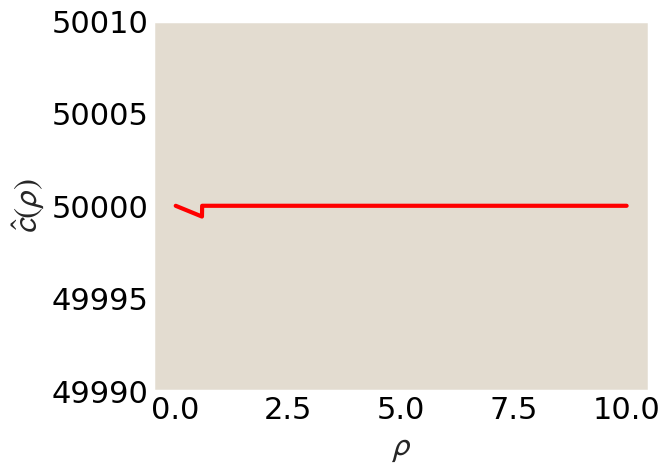

In [69]:
plt.plot(rhoMidVals, projCvalsForRho, color='r')
plt.ylim([h-10, h+10]) # to correctly emphasize that the scale of numerical variation is extremely miniscule, relative to magnitude of the (analytically-constant) profile
plt.ylabel(r'$\hat{c}(\rho)$')
plt.xlabel(r'$\rho$')

## (Correct) abel transform of simple exponential concentration profile

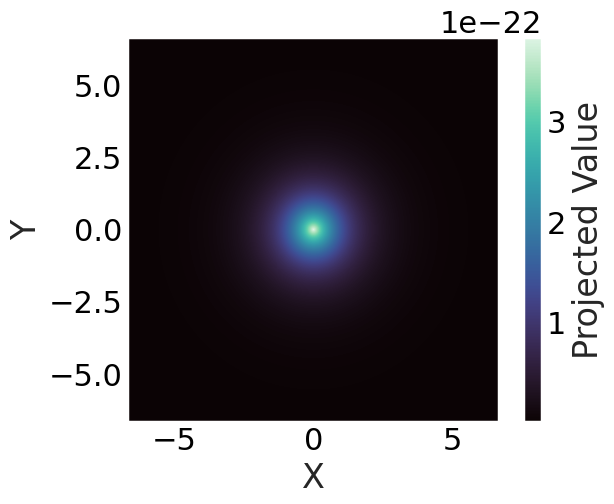

In [79]:
#### Verify numerical integral returns constant if integrand is 1 other than Jacobian part of the integral transform

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import seaborn as sns

# Define the integral function
def radialIntegral(rho, h):
    # If h <= rho, the integral doesn't produce a real positive value
    # We'll just return 0 in that case.
    if h <= rho:
        return 0.0
    def integrand(r):
        return (np.exp(-r)) * r / np.sqrt(r**2 - rho**2)
    #result, err = quad(integrand, rho, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)
    tiny=1e-10
    result, err = quad(integrand, rho+tiny, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)
    
    return result

# Example parameters
h = 50000  # large h value
rhoMin=0
rhoMax=10
rhoBinEdgeVals = np.linspace(rhoMin, rhoMax, num=5001)  # radial bin edges
rhoMidVals = (rhoBinEdgeVals[:-1] + rhoBinEdgeVals[1:]) / 2

# Compute the projection values for each annulus
projCvalsForRho = [radialIntegral(rho, h) for rho in rhoMidVals]

# For demonstration purposes, let's assume a 2D coordinate grid:
# Construct a mesh of points (X, Z) and compute their radial distance r_z0.
size = 1000
x = np.linspace(-rhoMax/1.5, rhoMax/1.5, size)
z = np.linspace(-rhoMax/1.5, rhoMax/1.5, size)
X, Z = np.meshgrid(x, z)
r_z0 = np.sqrt(X**2 + Z**2)

# Suppose C is a uniform array or some scalar field
C = np.ones((size, size))

# Build the projection map by assigning the integral result based on radial bins
projMap = np.zeros_like(C)
# for i in range(len(rhoMidVals)):
#     annulusMask = (r_z0 >= rhoBinEdgeVals[i]) & (r_z0 < rhoBinEdgeVals[i+1])
#     projMap[annulusMask] = projCvalsForRho[i]
for i in range(len(rhoMidVals)):
    annulusMask = (r_z0 >= rhoBinEdgeVals[i]) & (r_z0 <= rhoBinEdgeVals[i+1])
    projMap[annulusMask] = projCvalsForRho[i]

# Visualize the projection map
plt.figure(figsize=(6, 5))
# sns.heatmap(projMap, cmap="mako", cbar=True)
plt.imshow(projMap, 
           extent=[x.min(), x.max(), z.min(), z.max()],
           origin='lower', 
           aspect='auto', 
           cmap='mako')
plt.colorbar(label='Projected Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Text(0.5, 0, '$\\rho$')

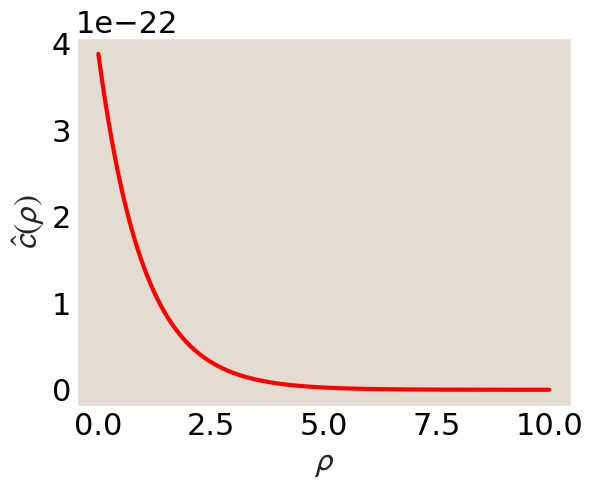

In [80]:
plt.plot(rhoMidVals, projCvalsForRho, color='r')
#plt.ylim([h-10, h+10]) # to correctly emphasize that the scale of numerical variation is extremely miniscule, relative to magnitude of the (analytically-constant) profile
plt.ylabel(r'$\hat{c}(\rho)$')
plt.xlabel(r'$\rho$')

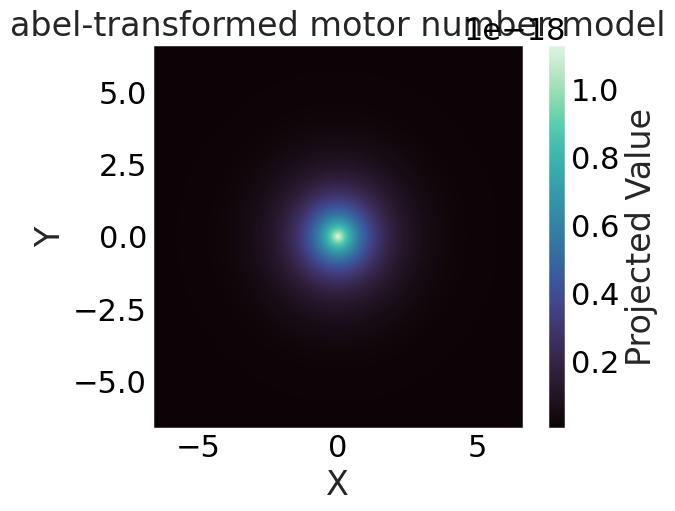

In [87]:
#### Verify numerical integral returns constant if integrand is 1 other than Jacobian part of the integral transform

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import seaborn as sns

# Define the integral function
def radialIntegral(rho, h):
    # If h <= rho, the integral doesn't produce a real positive value
    # We'll just return 0 in that case.
    if h <= rho:
        return 0.0
    def integrand(r):
        return (np.exp(-r)) * r**2 * (r / np.sqrt(r**2 - rho**2))
    #result, err = quad(integrand, rho, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)
    tiny=1e-10
    result, err = quad(integrand, rho+tiny, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)
    
    return result

# Example parameters
h = 50000  # large h value
rhoMin=0
rhoMax=10
rhoBinEdgeVals = np.linspace(rhoMin, rhoMax, num=5001)  # radial bin edges
rhoMidVals = (rhoBinEdgeVals[:-1] + rhoBinEdgeVals[1:]) / 2

# Compute the projection values for each annulus
projCvalsForRho = [radialIntegral(rho, h) for rho in rhoMidVals]

# For demonstration purposes, let's assume a 2D coordinate grid:
# Construct a mesh of points (X, Z) and compute their radial distance r_z0.
size = 1000
x = np.linspace(-rhoMax/1.5, rhoMax/1.5, size)
z = np.linspace(-rhoMax/1.5, rhoMax/1.5, size)
X, Z = np.meshgrid(x, z)
r_z0 = np.sqrt(X**2 + Z**2)

# Suppose C is a uniform array or some scalar field
C = np.ones((size, size))

# Build the projection map by assigning the integral result based on radial bins
projMap = np.zeros_like(C)
# for i in range(len(rhoMidVals)):
#     annulusMask = (r_z0 >= rhoBinEdgeVals[i]) & (r_z0 < rhoBinEdgeVals[i+1])
#     projMap[annulusMask] = projCvalsForRho[i]
for i in range(len(rhoMidVals)):
    annulusMask = (r_z0 >= rhoBinEdgeVals[i]) & (r_z0 <= rhoBinEdgeVals[i+1])
    projMap[annulusMask] = projCvalsForRho[i]

# Visualize the projection map
plt.figure(figsize=(6, 5))
# sns.heatmap(projMap, cmap="mako", cbar=True)
plt.imshow(projMap, 
           extent=[x.min(), x.max(), z.min(), z.max()],
           origin='lower', 
           aspect='auto', 
           cmap='mako')
plt.colorbar(label='Projected Value')
plt.title("abel-transformed motor number model")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Text(0.5, 0, '$\\rho$')

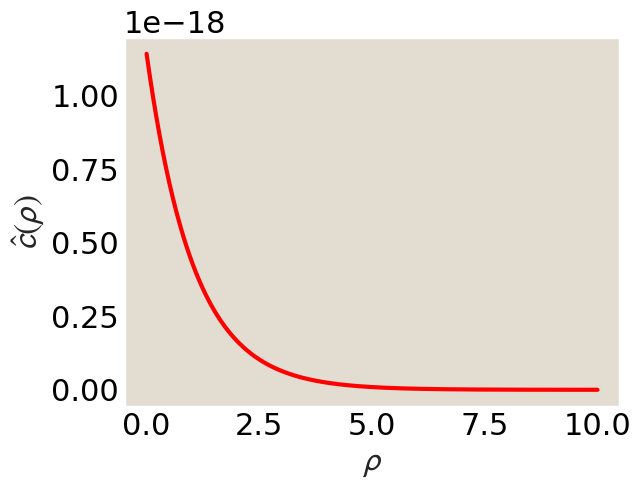

In [88]:
plt.plot(rhoMidVals, projCvalsForRho, color='r')
#plt.ylim([h-10, h+10]) # to correctly emphasize that the scale of numerical variation is extremely miniscule, relative to magnitude of the (analytically-constant) profile
plt.ylabel(r'$\hat{c}(\rho)$')
plt.xlabel(r'$\rho$')

### Try np.exp(+r), ATP 

/tmp/ipykernel_314847/751668703.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, err = quad(integrand, rho+tiny, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)


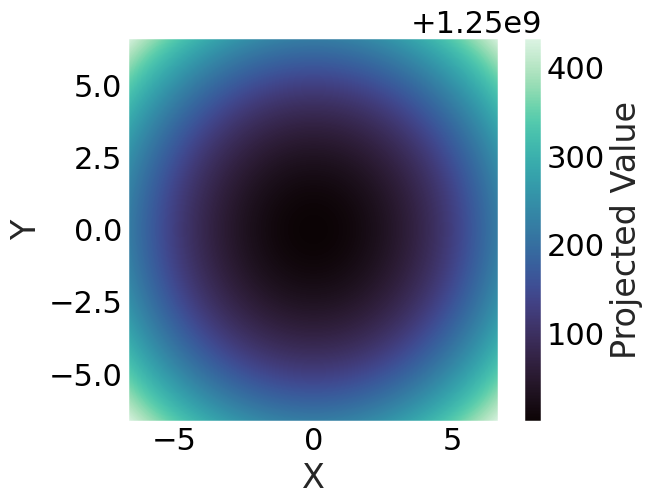

In [85]:
#### Verify numerical integral returns constant if integrand is 1 other than Jacobian part of the integral transform
""" LINEAR increasing gradient in r as proxy for ATP  """
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import seaborn as sns

# Define the integral function
def radialIntegral(rho, h):
    # If h <= rho, the integral doesn't produce a real positive value
    # We'll just return 0 in that case.
    if h <= rho:
        return 0.0
    def integrand(r):
        """ LINEAR increasing gradient in r as proxy for ATP  """
        return r * (r / np.sqrt(r**2 - rho**2))
    #result, err = quad(integrand, rho, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)
    tiny=1e-10
    result, err = quad(integrand, rho+tiny, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)
    
    return result

# Example parameters
h = 50000  # large h value
rhoMin=0
rhoMax=10
rhoBinEdgeVals = np.linspace(rhoMin, rhoMax, num=5001)  # radial bin edges
rhoMidVals = (rhoBinEdgeVals[:-1] + rhoBinEdgeVals[1:]) / 2

# Compute the projection values for each annulus
projCvalsForRho = [radialIntegral(rho, h) for rho in rhoMidVals]

# For demonstration purposes, let's assume a 2D coordinate grid:
# Construct a mesh of points (X, Z) and compute their radial distance r_z0.
size = 1000
x = np.linspace(-rhoMax/1.5, rhoMax/1.5, size)
z = np.linspace(-rhoMax/1.5, rhoMax/1.5, size)
X, Z = np.meshgrid(x, z)
r_z0 = np.sqrt(X**2 + Z**2)

# Suppose C is a uniform array or some scalar field
C = np.ones((size, size))

# Build the projection map by assigning the integral result based on radial bins
projMap = np.zeros_like(C)
# for i in range(len(rhoMidVals)):
#     annulusMask = (r_z0 >= rhoBinEdgeVals[i]) & (r_z0 < rhoBinEdgeVals[i+1])
#     projMap[annulusMask] = projCvalsForRho[i]
for i in range(len(rhoMidVals)):
    annulusMask = (r_z0 >= rhoBinEdgeVals[i]) & (r_z0 <= rhoBinEdgeVals[i+1])
    projMap[annulusMask] = projCvalsForRho[i]

# Visualize the projection map
plt.figure(figsize=(6, 5))
# sns.heatmap(projMap, cmap="mako", cbar=True)
plt.imshow(projMap, 
           extent=[x.min(), x.max(), z.min(), z.max()],
           origin='lower', 
           aspect='auto', 
           cmap='mako')
plt.colorbar(label='Projected Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Text(0.5, 0, '$\\rho$')

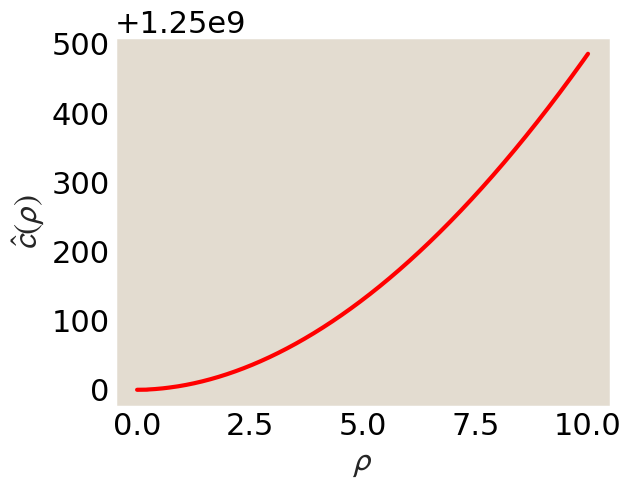

In [86]:
plt.plot(rhoMidVals, projCvalsForRho, color='r')
#plt.ylim([h-10, h+10]) # to correctly emphasize that the scale of numerical variation is extremely miniscule, relative to magnitude of the (analytically-constant) profile
plt.ylabel(r'$\hat{c}(\rho)$')
plt.xlabel(r'$\rho$')

### Try to confirm with fancier Numerical Abel package
* First, try our integral our way again but from rho to infinity, to match as closely as possible to `PyAbel`'s https://pyabel.readthedocs.io/en/latest/transform_methods/comparison.html#math

/tmp/ipykernel_314847/3506609597.py:19: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result, err = quad(integrand, rho+tiny, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)


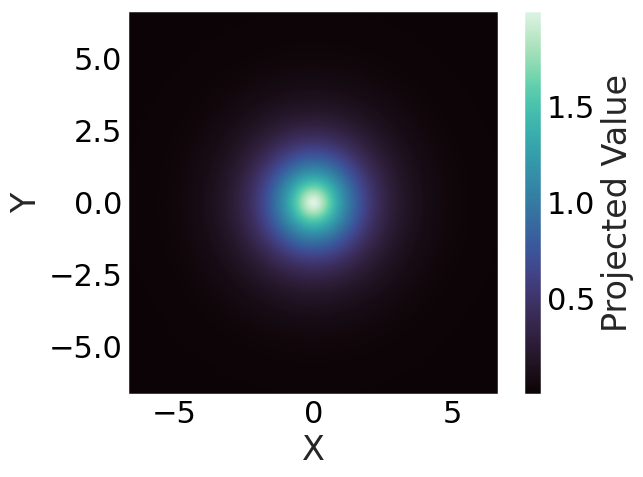

In [95]:
#### Verify numerical integral returns constant if integrand is 1 other than Jacobian part of the integral transform
## try to match PyAbel convention, https://pyabel.readthedocs.io/en/latest/transform_methods/comparison.html#math

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import seaborn as sns

# Define the integral function
def radialIntegral(rho, h):
    # If h <= rho, the integral doesn't produce a real positive value
    # We'll just return 0 in that case.
    if h <= rho:
        return 0.0
    def integrand(r):
        return 2*(np.exp(-r)) * r / np.sqrt(r**2 - rho**2)
    #result, err = quad(integrand, rho, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)
    tiny=1e-10
    result, err = quad(integrand, rho+tiny, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)
    
    return result

# Example parameters
h = np.inf # large h value
rhoMin=0
rhoMax=10
rhoBinEdgeVals = np.linspace(rhoMin, rhoMax, num=5001)  # radial bin edges
rhoMidVals = (rhoBinEdgeVals[:-1] + rhoBinEdgeVals[1:]) / 2

# Compute the projection values for each annulus
projCvalsForRho = [radialIntegral(rho, h) for rho in rhoMidVals]

# For demonstration purposes, let's assume a 2D coordinate grid:
# Construct a mesh of points (X, Z) and compute their radial distance r_z0.
size = 1000
x = np.linspace(-rhoMax/1.5, rhoMax/1.5, size)
z = np.linspace(-rhoMax/1.5, rhoMax/1.5, size)
X, Z = np.meshgrid(x, z)
r_z0 = np.sqrt(X**2 + Z**2)

# Suppose C is a uniform array or some scalar field
C = np.ones((size, size))

# Build the projection map by assigning the integral result based on radial bins
projMap = np.zeros_like(C)
# for i in range(len(rhoMidVals)):
#     annulusMask = (r_z0 >= rhoBinEdgeVals[i]) & (r_z0 < rhoBinEdgeVals[i+1])
#     projMap[annulusMask] = projCvalsForRho[i]
for i in range(len(rhoMidVals)):
    annulusMask = (r_z0 >= rhoBinEdgeVals[i]) & (r_z0 <= rhoBinEdgeVals[i+1])
    projMap[annulusMask] = projCvalsForRho[i]

# Visualize the projection map
plt.figure(figsize=(6, 5))
# sns.heatmap(projMap, cmap="mako", cbar=True)
plt.imshow(projMap, 
           extent=[x.min(), x.max(), z.min(), z.max()],
           origin='lower', 
           aspect='auto', 
           cmap='mako')
plt.colorbar(label='Projected Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Text(0.5, 0, '$\\rho$')

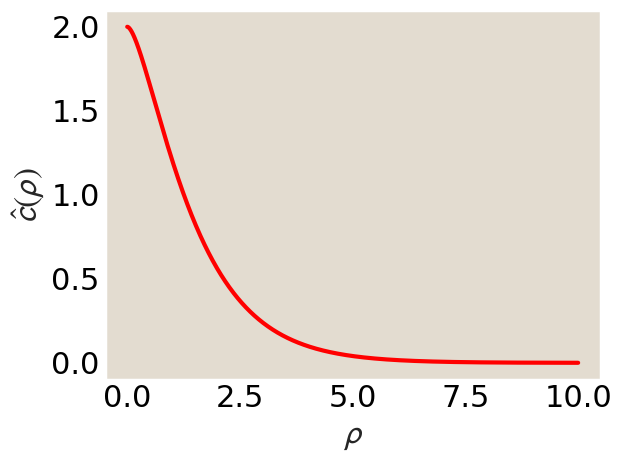

In [107]:
# plt.plot(rhoMidVals, projCvalsForRho, color='r')
plt.plot(rhoMidVals, projCvalsForRho, color='r')
#plt.ylim([h-10, h+10]) # to correctly emphasize that the scale of numerical variation is extremely miniscule, relative to magnitude of the (analytically-constant) profile
plt.ylabel(r'$\hat{c}(\rho)$')
plt.xlabel(r'$\rho$')

### Now try PyAbel version on this simple $c(r)=\exp[-r]$ example,

Falling back to a pure Python backend...
Falling back to a pure Python backend...
Falling back to a pure Python backend...
Falling back to a pure Python backend...


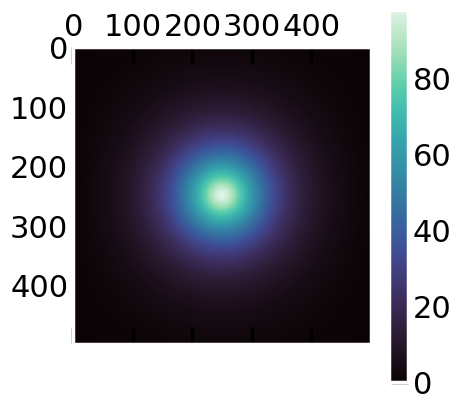

In [105]:
### First generate "original" simple c(r) slice
xVals=np.linspace(0,10,500)-5
yVals=np.linspace(0,10,500)-5
X, Y = np.meshgrid(xVals, yVals)
r_z0 = np.sqrt(X**2 + Y**2) # at z=0
C=np.exp(-r_z0)

# plt.matshow(C, cmap=sns.color_palette('mako', as_cmap=True))
# plt.colorbar()

originalCrSlice=C

## Next, transform using PyAbel forward transform,
import abel
forwardAbelConc=abel.Transform(originalCrSlice, direction='forward', method='direct').transform
plt.matshow(forwardAbelConc, cmap='mako')
plt.colorbar()

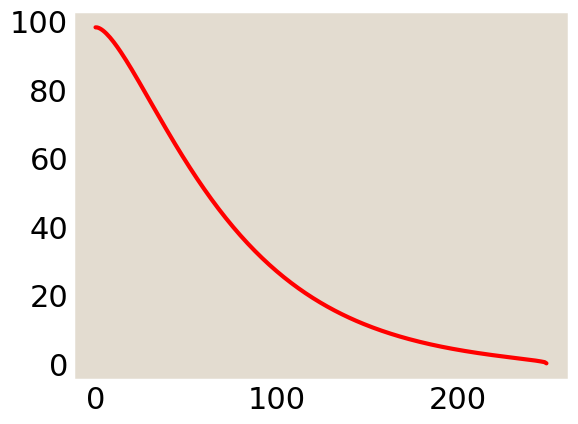

In [106]:
plt.plot(forwardAbelConc[500//2, 500//2:], 'r-')

#### That's bad, but let's plunge deeper into danger. Try to see if even any nonmonotonicity can be really recovered.

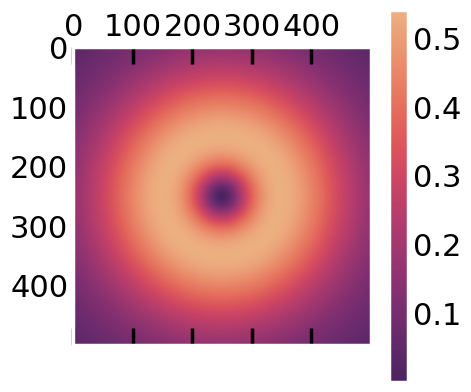

In [111]:
## First make our synthetic donut image of N(r),
originalRawNumMap=r_z0**2*np.exp(-r_z0)
plt.matshow(originalRawNumMap, cmap=sns.color_palette('flare_r', as_cmap=True))
plt.colorbar()

In [116]:
originalRawNumMap.shape

(500, 500)

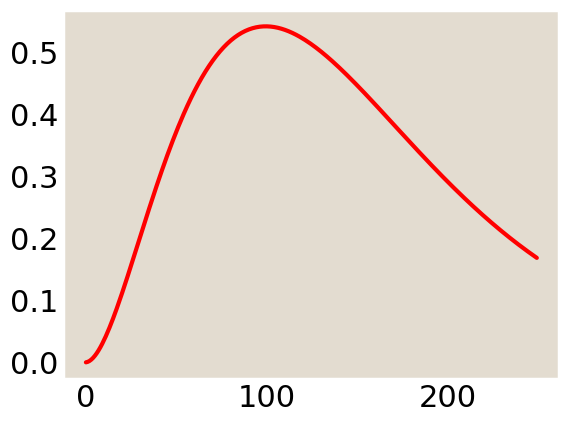

In [115]:
plt.plot(originalRawNumMap[500//2, 500//2:], 'r-')

/tmp/ipykernel_314847/1820041620.py:20: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result, err = quad(integrand, rho+tiny, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)
/tmp/ipykernel_314847/1820041620.py:20: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, err = quad(integrand, rho+tiny, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)
/tmp/ipy

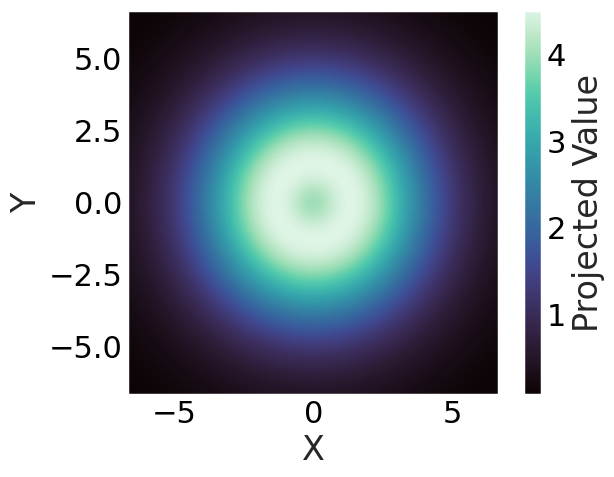

In [112]:
## Now try forward abel OUR WAY
#### Verify numerical integral returns constant if integrand is 1 other than Jacobian part of the integral transform
## try to match PyAbel convention, https://pyabel.readthedocs.io/en/latest/transform_methods/comparison.html#math

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import seaborn as sns

# Define the integral function
def radialIntegral(rho, h):
    # If h <= rho, the integral doesn't produce a real positive value
    # We'll just return 0 in that case.
    if h <= rho:
        return 0.0
    def integrand(r):
        return 2*(np.exp(-r)) *(r**2) * (r / np.sqrt(r**2 - rho**2))
    #result, err = quad(integrand, rho, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)
    tiny=1e-10
    result, err = quad(integrand, rho+tiny, np.sqrt(h**2 + rho**2),  epsabs=1e-12, epsrel=1e-12)
    
    return result

# Example parameters
h = np.inf # large h value
rhoMin=0
rhoMax=10
rhoBinEdgeVals = np.linspace(rhoMin, rhoMax, num=5001)  # radial bin edges
rhoMidVals = (rhoBinEdgeVals[:-1] + rhoBinEdgeVals[1:]) / 2

# Compute the projection values for each annulus
projCvalsForRho = [radialIntegral(rho, h) for rho in rhoMidVals]

# For demonstration purposes, let's assume a 2D coordinate grid:
# Construct a mesh of points (X, Z) and compute their radial distance r_z0.
size = 1000
x = np.linspace(-rhoMax/1.5, rhoMax/1.5, size)
z = np.linspace(-rhoMax/1.5, rhoMax/1.5, size)
X, Z = np.meshgrid(x, z)
r_z0 = np.sqrt(X**2 + Z**2)

# Suppose C is a uniform array or some scalar field
C = np.ones((size, size))

# Build the projection map by assigning the integral result based on radial bins
projMap = np.zeros_like(C)
# for i in range(len(rhoMidVals)):
#     annulusMask = (r_z0 >= rhoBinEdgeVals[i]) & (r_z0 < rhoBinEdgeVals[i+1])
#     projMap[annulusMask] = projCvalsForRho[i]
for i in range(len(rhoMidVals)):
    annulusMask = (r_z0 >= rhoBinEdgeVals[i]) & (r_z0 <= rhoBinEdgeVals[i+1])
    projMap[annulusMask] = projCvalsForRho[i]

# Visualize the projection map
plt.figure(figsize=(6, 5))
# sns.heatmap(projMap, cmap="mako", cbar=True)
plt.imshow(projMap, 
           extent=[x.min(), x.max(), z.min(), z.max()],
           origin='lower', 
           aspect='auto', 
           cmap='mako')
plt.colorbar(label='Projected Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Text(0.5, 0, '$\\rho$')

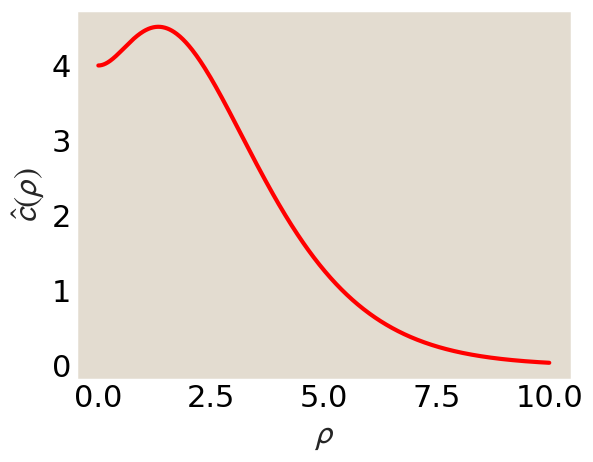

In [113]:
plt.plot(rhoMidVals, projCvalsForRho, color='r')
#plt.ylim([h-10, h+10]) # to correctly emphasize that the scale of numerical variation is extremely miniscule, relative to magnitude of the (analytically-constant) profile
plt.ylabel(r'$\hat{c}(\rho)$')
plt.xlabel(r'$\rho$')

## does the PyAbel forward also look like this?

Falling back to a pure Python backend...
Falling back to a pure Python backend...
Falling back to a pure Python backend...
Falling back to a pure Python backend...


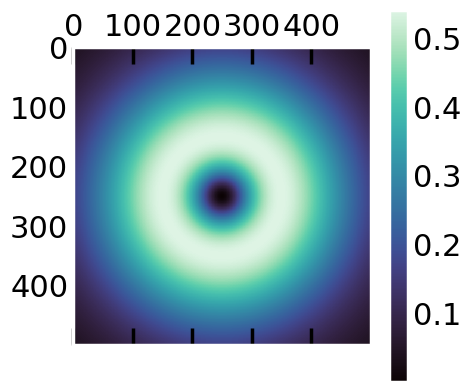

In [117]:
## Next, transform using PyAbel forward transform,
import abel
forwardAbelConc=abel.Transform(originalRawNumMap, direction='forward', method='direct').transform
plt.matshow(originalRawNumMap, cmap='mako')
plt.colorbar()

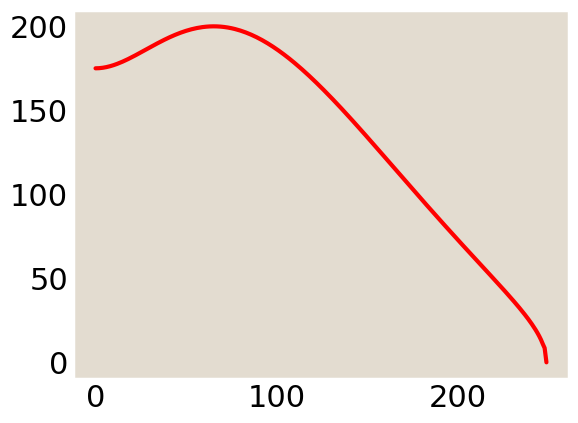

In [118]:
plt.plot(forwardAbelConc[500//2, 500//2:], 'r-')

### Well, shucks. This forward transform looks noticeably different than our version, quantitatively. But there still is a peak!

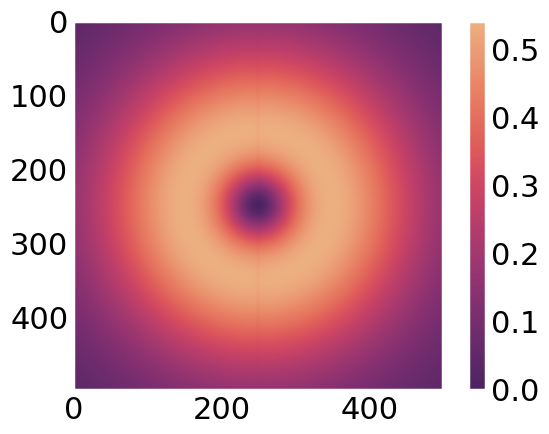

In [120]:
## Try the inverse on PyAbel's own, to see if idempotent
invAbelOnFwdAbel=abel.Transform(forwardAbelConc, direction='inverse',
                              method='three_point').transform
plt.imshow(invAbelOnFwdAbel, cmap=sns.color_palette('flare_r', as_cmap=True))
plt.colorbar()

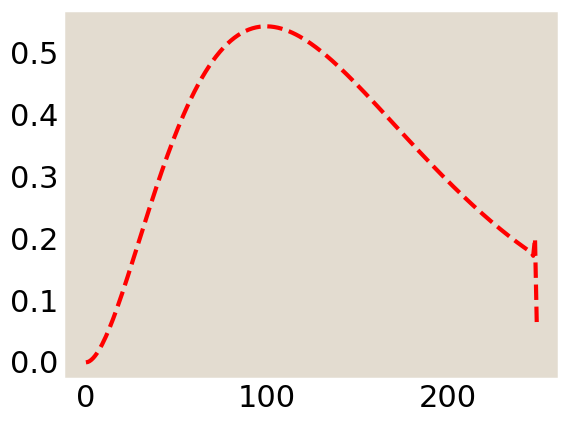

In [121]:
plt.plot(invAbelOnFwdAbel[500//2, 500//2:], 'r--')

##### This is pretty damn good, eg. fairly idempotent indeed, at least inside the package!

### Now try PyAbel's inverse on our forward,

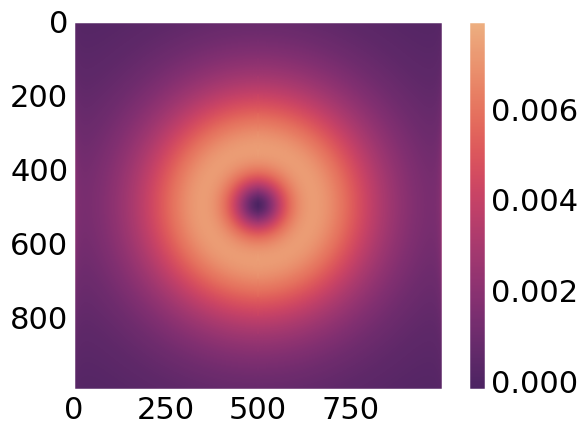

In [123]:
## Try the inverse on PyAbel's own, to see if idempotent
invAbelOnOurs=abel.Transform(projMap, direction='inverse',
                              method='three_point').transform
plt.imshow(invAbelOnOurs, cmap=sns.color_palette('flare_r', as_cmap=True))
plt.colorbar()

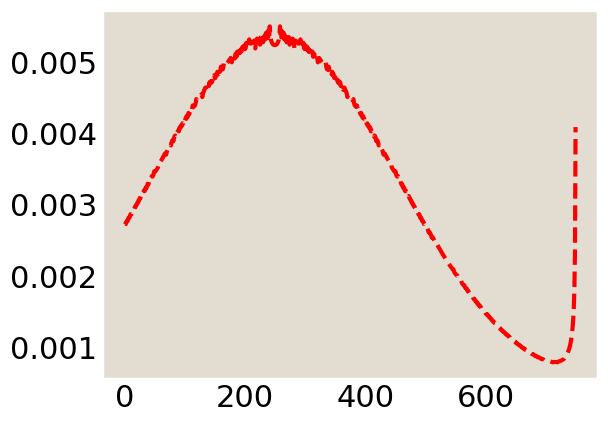

In [124]:
plt.plot(invAbelOnOurs[500//2, 500//2:], 'r--')

# We conclude a few things from the above:
* A forward Abel transform 
___

In [37]:
# import numpy as np
# import scipy.integrate as integrate

# def integrand(r, rho):
#     return r / np.sqrt(r**2 - rho**2)

# def numeric_verify(rho, h):
#     # Only valid if h > rho
#     if h <= rho:
#         return np.nan
    
#     result, error = integrate.quad(integrand, rho, h, args=(rho,))
#     return result

# # Test for some values
# rho_test = 2.0
# h_test = 5.0

# numerical_result = numeric_verify(rho_test, h_test)
# analytical_result = np.sqrt(h_test**2 - rho_test**2)

# print("Numerical:", numerical_result)
# print("Analytical:", analytical_result)
# print("Difference:", numerical_result - analytical_result)

In [73]:
### It weirdly looks like the abel transform map is very powerful---it seems to overpower the effect in the original number distribution that, for small r, the volume of shells ~ r^2 is small ??
### 

# See if numerical abel inversion is apparently possible for this example

In [76]:
## install pyabel
import os
import sys

os.system(f'"{sys.executable}" -m pip install pyabel')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 3.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pyabel: filename=PyAbel-0.9.0-py3-none-any.whl size=155107 sha256=52833ae39e4303f0e4bc1341e3f593a46fc4fd32ab14da87fcbf009f84490a4f
  Stored in directory: /home/gsalmon/.cache/pip/wheels/c8/08/d0/961e562d7a2e378b3eb024734d63e8c41d88106c754f98eb54
Successfully built pyabel



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: /home/gsalmon/dedalus3/bin/python -m pip install --upgrade pip


0

In [78]:
### Run PyAbel on this mini example
import abel

### The below are with the old (eg wrong) forward-integral-computation from earlier. 

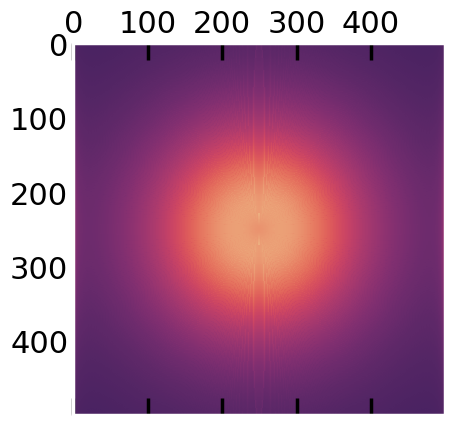

In [96]:
# inverse_abel = abel.Transform(projMap_Num, direction='inverse',
#                               method='three_point').transform
# plt.matshow(inverse_abel, cmap=sns.color_palette('flare_r', as_cmap=True))

Falling back to a pure Python backend...
Falling back to a pure Python backend...
Falling back to a pure Python backend...
Falling back to a pure Python backend...


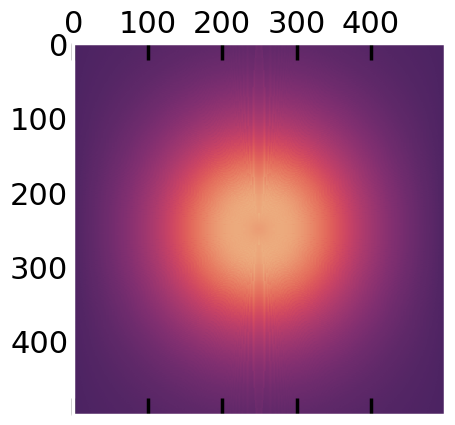

In [87]:
# inverse_abel = abel.Transform(projMap_Num, direction='inverse',
#                               method='direct').transform
# plt.matshow(inverse_abel, cmap=sns.color_palette('flare_r', as_cmap=True))

Using memory-cached basis sets
Using memory-cached basis sets
Using memory-cached basis sets
Using memory-cached basis sets


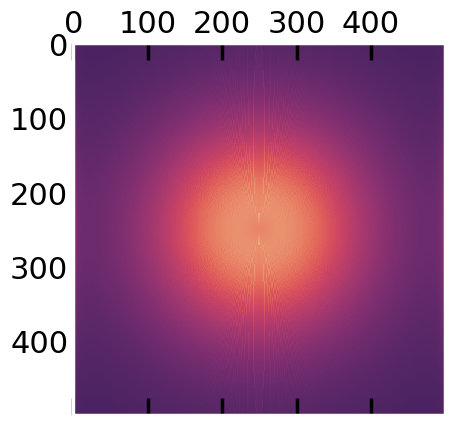

In [86]:
# inverse_abel = abel.Transform(projMap_Num, direction='inverse',
#                               method='basex').transform
# plt.matshow(inverse_abel, cmap=sns.color_palette('flare_r', as_cmap=True))#, cmap='ocean_r')

Generating basis projections for n = 250, degree = 0...


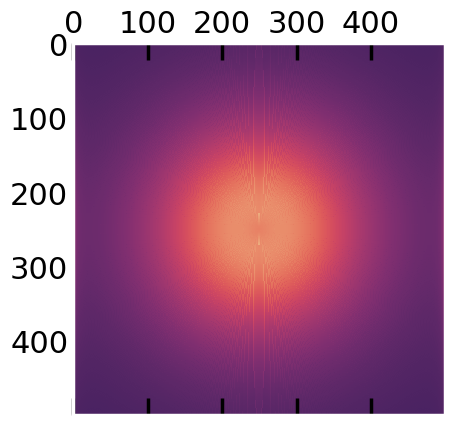

In [89]:
# inverse_abel = abel.Transform(projMap_Num, direction='inverse',
#                               method='daun').transform
# plt.matshow(inverse_abel, cmap=sns.color_palette('flare_r', as_cmap=True))#, cmap='ocean_r')

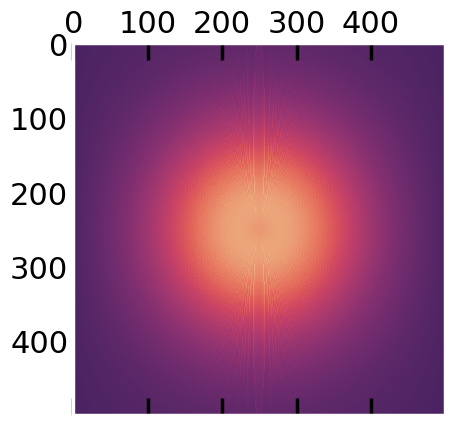

In [90]:
# inverse_abel = abel.Transform(projMap_Num, direction='inverse',
#                               method='hansenlaw').transform
# plt.matshow(inverse_abel, cmap=sns.color_palette('flare_r', as_cmap=True))#, cmap='ocean_r')

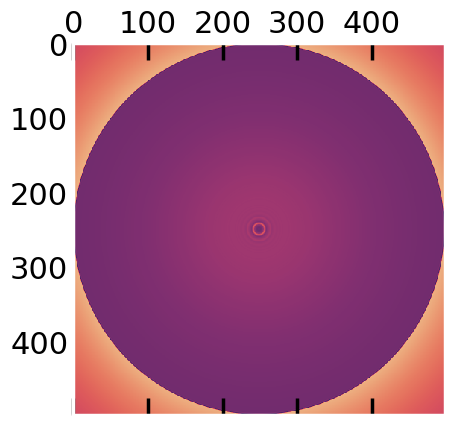

In [92]:
# inverse_abel = abel.Transform(projMap_Num[:-1,:-1], direction='inverse',
#                               method='linbasex').transform
# plt.matshow(inverse_abel, cmap=sns.color_palette('flare_r', as_cmap=True))#, cmap='ocean_r')

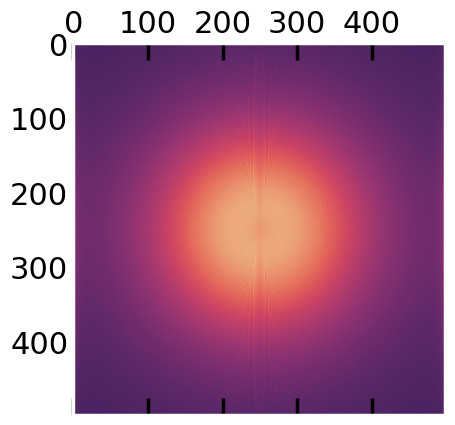

In [93]:
# inverse_abel = abel.Transform(projMap_Num[:-1,:-1], direction='inverse',
#                               method='onion_bordas').transform
# plt.matshow(inverse_abel, cmap=sns.color_palette('flare_r', as_cmap=True))#, cmap='ocean_r')

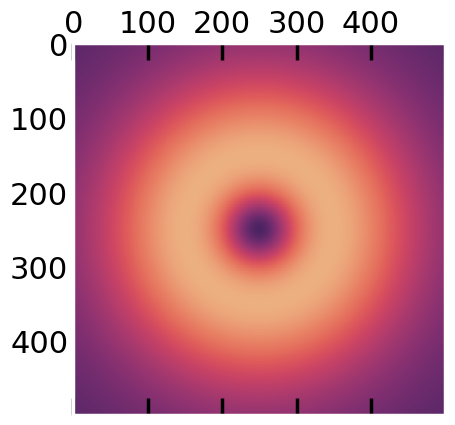

In [94]:
# originalRawNumMap=4*np.pi*r_z0**2*np.exp(-r_z0)
# plt.matshow(originalRawNumMap, cmap=sns.color_palette('flare_r', as_cmap=True))